# Basic imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

pd.set_option("display.max_columns", None)

In [2]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!pip install torchtyping
from torchtyping import TensorType

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


# Data preparation

## Download Apple's stock prices dataset

In [5]:
apple_stocks = yf.download("AAPL", period="max")

[*********************100%***********************]  1 of 1 completed


In [6]:
apple_stocks.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091631,73449600


In [7]:
apple_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11035 entries, 1980-12-12 to 2024-09-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       11035 non-null  float64
 1   High       11035 non-null  float64
 2   Low        11035 non-null  float64
 3   Close      11035 non-null  float64
 4   Adj Close  11035 non-null  float64
 5   Volume     11035 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 603.5 KB


## Get rid of unnecessary columns

In [8]:
FEATURES_TO_PREPARE = ['Close', 'Volume']
data = apple_stocks[FEATURES_TO_PREPARE].copy()
data.head()

,Close,Volume
Date,,
1980-12-12,0.128348,469033600
1980-12-15,0.121652,175884800
1980-12-16,0.112723,105728000
1980-12-17,0.115513,86441600
1980-12-18,0.118862,73449600


## Plot the `Close` prices

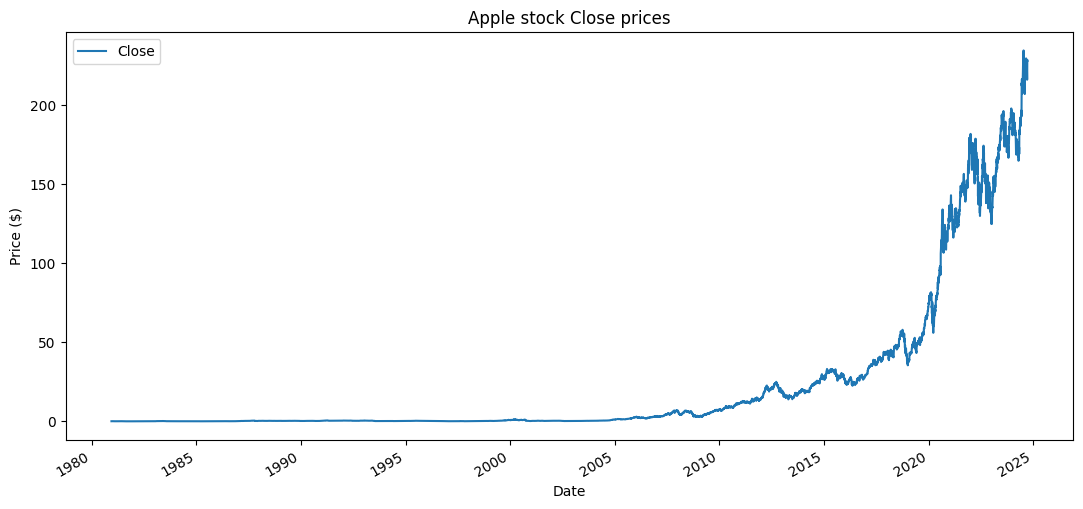

In [9]:
ax = data['Close'].plot(figsize=(13, 6), title="Apple stock Close prices", legend=True)
ax.set_ylabel("Price ($)")
plt.show()

## Get rid of stock prices before 2005-01-01 as their value stayed almost the same

In [10]:
data = data.loc['2005-01-01':]

## Plot the `Volume` distribiution

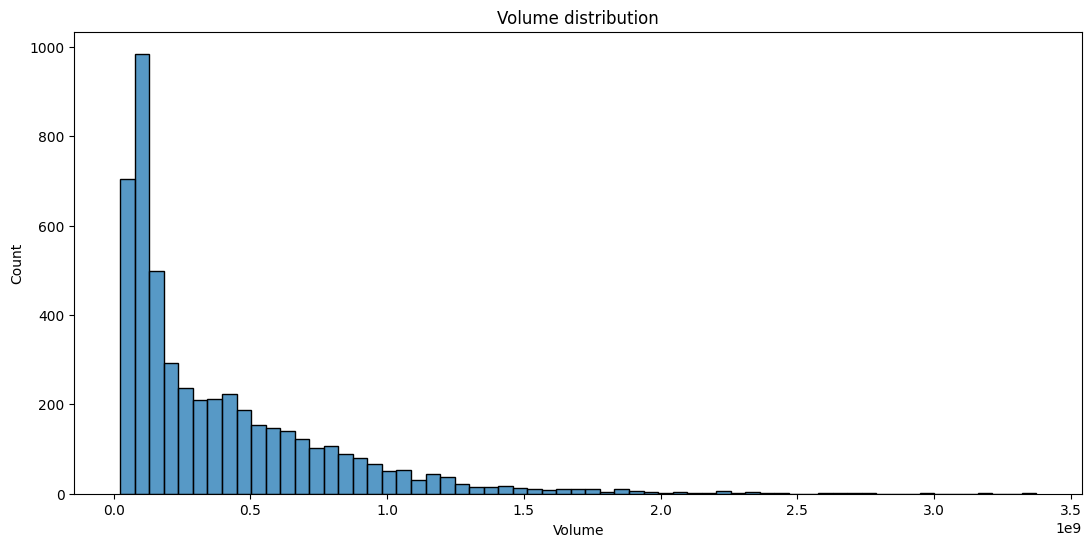

In [11]:
plt.figure(figsize=(13, 6))
ax = sns.histplot(data['Volume'])
plt.title("Volume distribution")
plt.show()

## Splitting the data into test and train

Leave 182 days for the testing purpose and 7 days gap between test and train to
prevent data leakage

In [12]:
TEST_LEN = 182 + 7
SPLIT_INDEX = len(data) - TEST_LEN

train_data = data.iloc[:SPLIT_INDEX].copy()
test_data = data.iloc[SPLIT_INDEX:].copy()

## Applying the quantile transformation on `Volume` to handle the skewness

In [13]:
transformer = QuantileTransformer(output_distribution='normal')

train_data['Volume'] = transformer.fit_transform(train_data['Volume'].to_numpy().reshape(-1, 1))
test_data['Volume'] = transformer.transform(test_data['Volume'].to_numpy().reshape(-1, 1))

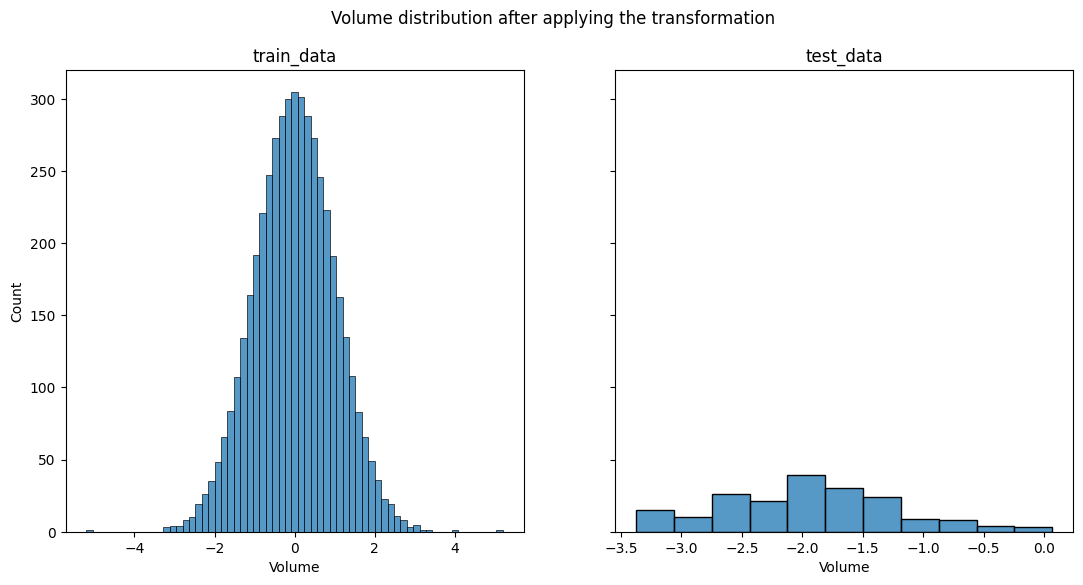

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13, 6))
fig.suptitle("Volume distribution after applying the transformation")

ax1.set_title("train_data")
sns.histplot(train_data['Volume'], ax=ax1)

ax2.set_title("test_data")
sns.histplot(test_data['Volume'], ax=ax2)

plt.show()

## Scale the `Close` column

In [15]:
scaler = StandardScaler()

train_data['Close'] = scaler.fit_transform(train_data['Close'].to_numpy().reshape(-1, 1))
test_data['Close'] = scaler.transform(test_data['Close'].to_numpy().reshape(-1, 1))

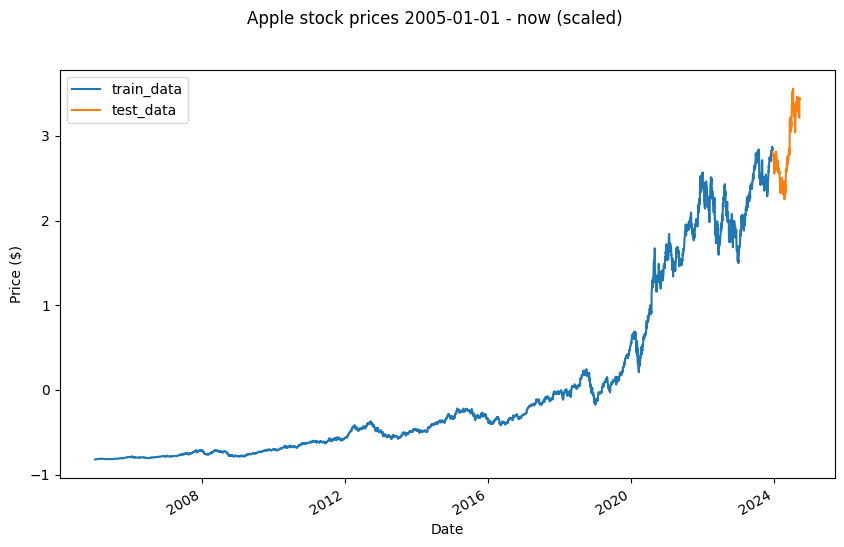

In [16]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Apple stock prices 2005-01-01 - now (scaled)")
ax1 = train_data['Close'].plot()
ax2 = test_data['Close'].plot()
plt.ylabel("Price ($)")
plt.legend(['train_data', 'test_data'])
plt.show()

## Add lagged features

In [17]:
from typing import List

def create_lagged_features(df: pd.DataFrame, feature_names: List[str] | str, n_features: int) -> pd.DataFrame:
    """
    Generate lagged features for one or more specified columns in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the time series data.
        feature_names (List[str] | str): The name of the column or list of columns for which to create lagged features.
        n_features (int): Number of lagged features to create for each column.

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for each lagged feature.
                      If multiple columns are provided, lagged features are created for each,
                      named '{feature_name}(t - 1)', '{feature_name}(t - 2)', ..., up to '{feature_name}(t - n)'.
    """
    df = df.copy()

    if isinstance(feature_names, list):
        for i in range(n_features):
            shifted_df = df.shift(i + 1)
            for feature_name in feature_names:
                df[f'{feature_name}(t - {i + 1})'] = shifted_df[feature_name]

    else:
        feature_name = feature_names
        for i in range(n_features):
            df[f'{feature_name}(t - {i + 1})'] = df[feature_name].shift(i + 1)


    return df

In [18]:
SEQUENCE_LEN = 7

train_data = create_lagged_features(train_data, feature_names=FEATURES_TO_PREPARE, n_features=SEQUENCE_LEN).dropna()
test_data = create_lagged_features(test_data, feature_names=FEATURES_TO_PREPARE, n_features=SEQUENCE_LEN).dropna()
test_data.head(SEQUENCE_LEN + 1)

,Close,Volume,Close(t - 1),Volume(t - 1),Close(t - 2),Volume(t - 2),Close(t - 3),Volume(t - 3),Close(t - 4),Volume(t - 4),Close(t - 5),Volume(t - 5),Close(t - 6),Volume(t - 6),Close(t - 7),Volume(t - 7)
Date,,,,,,,,,,,,,,,,
2024-01-02,2.636928,-1.102980,2.766051,-2.624828,2.785729,-3.172115,2.777670,-2.207473,2.775796,-3.375422,2.786104,-3.093473,2.806343,-2.309919,2.809155,-1.989430
2024-01-03,2.610878,-1.738575,2.636928,-1.102980,2.766051,-2.624828,2.785729,-3.172115,2.777670,-2.207473,2.775796,-3.375422,2.786104,-3.093473,2.806343,-2.309919
2024-01-04,2.567025,-1.345698,2.610878,-1.738575,2.636928,-1.102980,2.766051,-2.624828,2.785729,-3.172115,2.777670,-2.207473,2.775796,-3.375422,2.786104,-3.093473
2024-01-05,2.553344,-1.622121,2.567025,-1.345698,2.610878,-1.738575,2.636928,-1.102980,2.766051,-2.624828,2.785729,-3.172115,2.777670,-2.207473,2.775796,-3.375422
2024-01-08,2.635429,-1.709895,2.553344,-1.622121,2.567025,-1.345698,2.610878,-1.738575,2.636928,-1.102980,2.766051,-2.624828,2.785729,-3.172115,2.777670,-2.207473
2024-01-09,2.627557,-2.613641,2.635429,-1.709895,2.553344,-1.622121,2.567025,-1.345698,2.610878,-1.738575,2.636928,-1.102980,2.766051,-2.624828,2.785729,-3.172115
2024-01-10,2.647235,-2.283092,2.627557,-2.613641,2.635429,-1.709895,2.553344,-1.622121,2.567025,-1.345698,2.610878,-1.738575,2.636928,-1.102980,2.766051,-2.624828
2024-01-11,2.635991,-2.133053,2.647235,-2.283092,2.627557,-2.613641,2.635429,-1.709895,2.553344,-1.622121,2.567025,-1.345698,2.610878,-1.738575,2.636928,-1.102980


## Split the data into X and y

In [19]:
FEATURES = [f'{feature_name}(t - {i + 1})' for i in range(SEQUENCE_LEN) for feature_name in FEATURES_TO_PREPARE]
TARGET = 'Close'
FEATURES

['Close(t - 1)',
 'Volume(t - 1)',
 'Close(t - 2)',
 'Volume(t - 2)',
 'Close(t - 3)',
 'Volume(t - 3)',
 'Close(t - 4)',
 'Volume(t - 4)',
 'Close(t - 5)',
 'Volume(t - 5)',
 'Close(t - 6)',
 'Volume(t - 6)',
 'Close(t - 7)',
 'Volume(t - 7)']

In [20]:
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

In [21]:
X_test = test_data[FEATURES]
y_test = test_data[TARGET]

## Converting the data to `torch.Tensor`'s

In [22]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()
X_train.shape, y_train.shape

(torch.Size([4767, 14]), torch.Size([4767]))

In [23]:
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.from_numpy(y_test.to_numpy()).float()
X_test.shape, y_test.shape

(torch.Size([182, 14]), torch.Size([182]))

## Reshaping X into (N, L, H_in) and y into (N, H_out)

In [24]:
H_in = 2 # input size

In [25]:
X_train = X_train.reshape((-1, SEQUENCE_LEN, H_in))
y_train = y_train.reshape(-1, 1)
X_train.shape, y_train.shape

(torch.Size([4767, 7, 2]), torch.Size([4767, 1]))

In [26]:
X_test = X_test.reshape((-1, SEQUENCE_LEN, H_in))
y_test = y_test.reshape(-1, 1)
X_test.shape, y_test.shape

(torch.Size([182, 7, 2]), torch.Size([182, 1]))

## Convert the data into `TensorDataset`'s and create `DataLoader`'s

In [27]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

BATCH_SIZE = 16

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

sample_X, sample_y = next(iter(train_dataloader))
sample_X[0], sample_y[0]

(tensor([[-0.4862, -0.1362],
         [-0.4866, -0.2090],
         [-0.4907,  0.0630],
         [-0.4947, -0.0990],
         [-0.4954,  0.0184],
         [-0.4929, -0.1236],
         [-0.4943,  0.0282]]),
 tensor([-0.4909]))

# Create LSTM model

## Define the LSTM class

In [28]:
class LSTM(nn.Module):
    """
    A simple LSTM model for sequence prediction.

    Args:
        n_input (int): The number of input features.
        n_hidden (int): The number of hidden units in the LSTM layer.
        n_layers (int): The number of LSTM layers stacked on top of each other.

    Attributes:
        lstm (nn.LSTM): The LSTM layer.
        l1 (nn.Linear): The linear layer that produces the final output.

    Methods:
        forward(X: TensorType[torch.float32]) -> TensorType[torch.float32]:
            Passes the input tensor through the LSTM layer and the subsequent linear layer to produce the output.
    """
    def __init__(self, n_input: int, n_hidden: int, n_layers: int) -> None:
        """
        Initializes the LSTM model with specified input features, hidden units, and layers.

        Args:
            n_input (int): Number of input features.
            n_hidden (int): Number of hidden units in the LSTM layer.
            n_layers (int): Number of LSTM layers.
        """
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=0.2)
        self.l1 = nn.Linear(n_hidden, 1)

    def forward(self, X: TensorType[torch.float32]) -> TensorType[torch.float32]:
        """
        Defines the forward pass of the LSTM model.

        Args:
            X (TensorType[torch.float32]): Input tensor with shape (batch_size, seq_length, n_input).

        Returns:
            TensorType[torch.float32]: Output tensor with shape (batch_size, 1).
        """
        output, _ = self.lstm(X)
        output = self.l1(output[:, -1, :])
        return output

## Define `train_epoch` and `test_epoch` functions

In [29]:
def train_epoch(dataloader: DataLoader, optimizer: optim.Optimizer, loss_fn: nn.modules.loss._Loss) -> None:
    """
    Trains a model for one epoch using the provided dataloader, optimizer, and loss function.

    This function iterates over the training data in batches, computes the loss, performs backpropagation,
    and updates the model's weights using the optimizer. It also tracks and prints the current and average loss
    after every 10 batches.

    Args:
        dataloader (DataLoader): The DataLoader providing the training data in batches.
        optimizer (optim.Optimizer): The optimizer used to update the model's weights.
        loss_fn (nn.modules.loss._Loss): The loss function used to compute the difference between predictions and targets.

    Returns:
        None
    """
    avg_loss = 0.0

    model.train()
    for batch_index, (X, y) in enumerate(train_dataloader, 1):
        X, y = X.to(device), y.to(device)

        prediction = model(X)
        loss = loss_fn(prediction, y)

        avg_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            loss = loss.item()
            current_sample = batch_index * len(X)

            print(f'Current loss: {loss:.5f}, Average loss: {avg_loss / 10:.5f} [{current_sample} / {len(dataloader.dataset)}]')
            avg_loss = 0.0

In [30]:
def test_epoch(dataloader: DataLoader, loss_fn: nn.modules.loss._Loss) -> None:
    """
    Evaluates the model's performance on the test dataset for one epoch.

    This function iterates over the test data, computes the loss for each batch, and
    calculates the average loss across all batches. The model is set to evaluation mode
    to disable dropout and other training-specific behaviors.

    Args:
        dataloader (DataLoader): The DataLoader providing the test data in batches.
        loss_fn (nn.modules.loss._Loss): The loss function used to compute the difference between predictions and targets.

    Returns:
        None
    """
    model.eval()

    avg_test_loss = 0.0

    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            prediction = model(X)

            loss = loss_fn(prediction, y)
            avg_test_loss += loss.item()

    print(f'Average test loss: {avg_test_loss / len(test_data):.5f}')

In [63]:
model = LSTM(2, 128, 5).to(device)
model

LSTM(
  (lstm): LSTM(2, 128, num_layers=5, batch_first=True, dropout=0.2)
  (l1): Linear(in_features=128, out_features=1, bias=True)
)

## Define loss function and optimizer

In [64]:
LEARNING_RATE = 3e-5

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train the model

In [65]:
N_EPOCHS = 20

for epoch in range(N_EPOCHS):
    print(f"|--------------------------{epoch + 1}/{N_EPOCHS}--------------------------|")
    train_epoch(train_dataloader, optimizer, loss_fn)
    test_epoch(test_dataloader, loss_fn)



|--------------------------1/20--------------------------|
Current loss: 1.25952, Average loss: 0.98310 [160 / 4767]
Current loss: 0.23976, Average loss: 0.82714 [320 / 4767]
Current loss: 0.75535, Average loss: 0.76735 [480 / 4767]
Current loss: 0.83409, Average loss: 0.83357 [640 / 4767]
Current loss: 2.22525, Average loss: 1.08290 [800 / 4767]
Current loss: 1.31684, Average loss: 1.07755 [960 / 4767]
Current loss: 0.77549, Average loss: 1.02202 [1120 / 4767]
Current loss: 1.88154, Average loss: 0.91840 [1280 / 4767]
Current loss: 0.39470, Average loss: 0.97642 [1440 / 4767]
Current loss: 1.16360, Average loss: 1.29306 [1600 / 4767]
Current loss: 0.34812, Average loss: 0.90664 [1760 / 4767]
Current loss: 0.84658, Average loss: 0.95602 [1920 / 4767]
Current loss: 1.29667, Average loss: 1.05689 [2080 / 4767]
Current loss: 0.57774, Average loss: 0.98625 [2240 / 4767]
Current loss: 0.87261, Average loss: 1.19302 [2400 / 4767]
Current loss: 0.28338, Average loss: 0.67971 [2560 / 4767]
Cur

## Test the model

In [66]:
test_data = pd.DataFrame(data.iloc[SPLIT_INDEX + 7:]['Close'])
test_data = test_data.rename(columns={'Close': 'Actual'})

In [67]:
model.eval()
with torch.no_grad():
    predicted = model(X_test.to(device))

## Undo the scaling

In [68]:
predicted = scaler.inverse_transform(predicted.cpu().numpy())

In [69]:
test_data['Predicted'] = predicted
test_data.head()

,Actual,Predicted
Date,,
2024-01-02,185.639999,196.357376
2024-01-03,184.250000,194.517456
2024-01-04,181.910004,192.075378
2024-01-05,181.179993,189.587723
2024-01-08,185.559998,187.589539


# Compare results with actual data

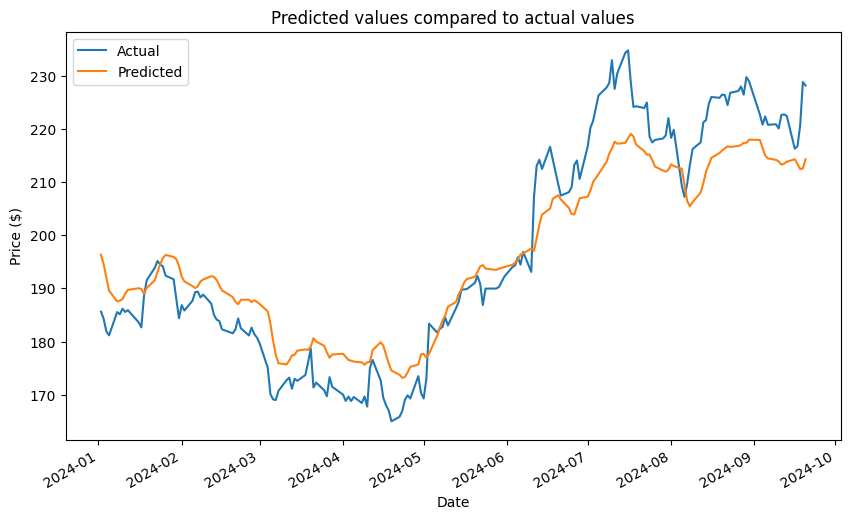

In [70]:
ax = test_data.plot(figsize=(10, 6), title="Predicted values compared to actual values")
ax.set_ylabel("Price ($)")
plt.show()